### Run with TF 1.2 (python 3.5)

### There is NO backwards compatibility (does not run on TF 1.0 or earlier)

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('..','object_detection', 'data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

### Run test to make sure the env is setup correctly
Make sure to follow installation instructions and laid out in:

https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md

Output should be:


In [5]:
%run ../object_detection/builders/model_builder_test.py

.......
----------------------------------------------------------------------
Ran 7 tests in 0.049s

OK


If test fails, try running the following in terminal before launching Jupyter kernel

(As follows from the installation instructions)

### If test is successful, resume here:

## Download Model

(Might take a while, downloads ~128MB)

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [8]:
def load_image_into_numpy_array(image):
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [os.path.join(
    '..', 
    'object_detection', 
    PATH_TO_TEST_IMAGES_DIR, 
    'image{}.jpg'.format(i)) for i in range(1, 3)]

# Size, in inches, of the output images.
image_scaling_factor = 1.5
IMAGE_SIZE = (12*image_scaling_factor, 
              8*image_scaling_factor)

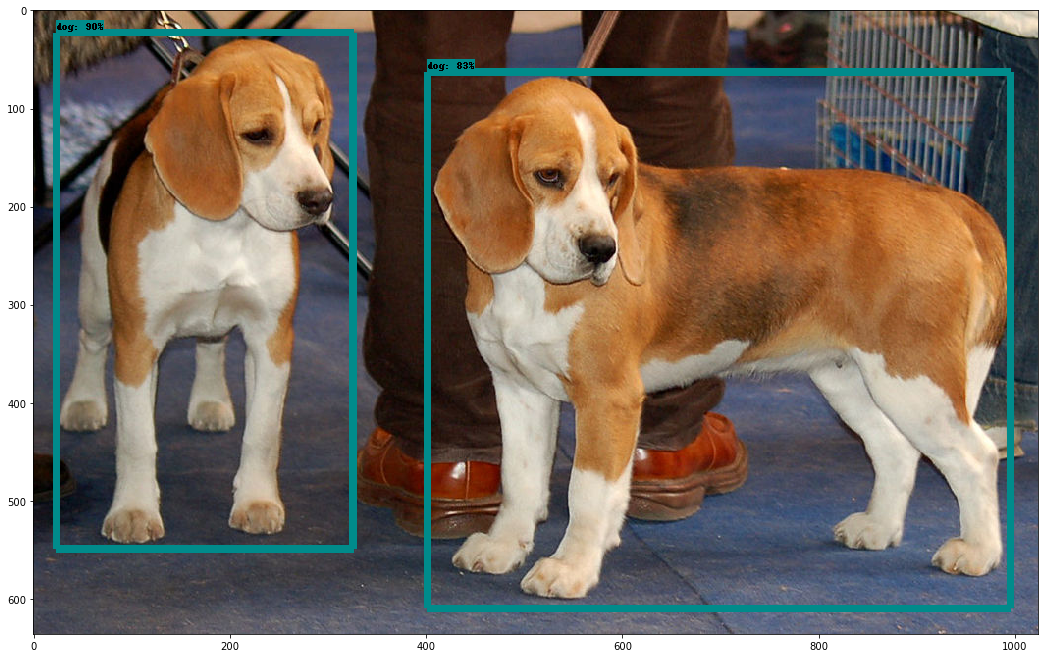

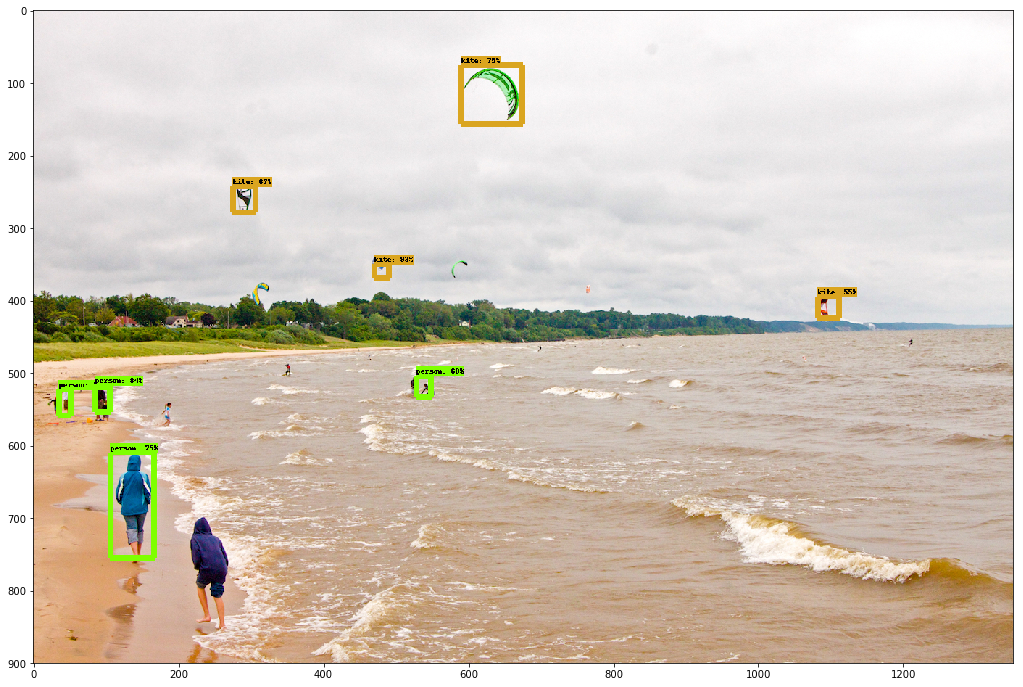

In [10]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

## Draw boxes (ground truth)

In [11]:
# load labels
training_labels = pd.read_csv(os.path.join(
    '..', 
    'image_resources', 
    'training_labels.csv'))

test_labels = pd.read_csv(os.path.join(
    '..', 
    'image_resources', 
    'test_labels.csv'))

all_labels = pd.concat(
    [training_labels, test_labels], ignore_index=True)

In [12]:
def draw_boxes_from_img(img_fname, 
                        img_set, 
                        labels=all_labels, 
#                         labels, 
                        fig_width=16, 
                        fig_height=24):
    """
    Takes as inputs:
    img_fname, img_set, strings of the image file name and the containing directory.
    Optional args:
    labels => pandas df with the label information
    fig_width, fig_height => (int, int)
    """

#     img_fname = '1.png'
#     img_set = 'training_set'

#     labels = all_labels

    # get image label params
    row = labels[labels.filename == img_fname]
    rect_x = row.xmin
    rect_y = row.ymin
    rect_width = row.xmax -rect_x
    rect_height = row.ymax - rect_y

    # load image
    im = np.array(Image.open(os.path.join(
        '..', 
        'image_resources',
        img_set,
        img_fname)), 
                  dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (rect_x,rect_y),  # (x,y)
        rect_width,rect_height,  # width, height
        linewidth=3,edgecolor='lime',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    fig.set_figwidth(fig_width)
    fig.set_figheight(fig_height)

    return plt

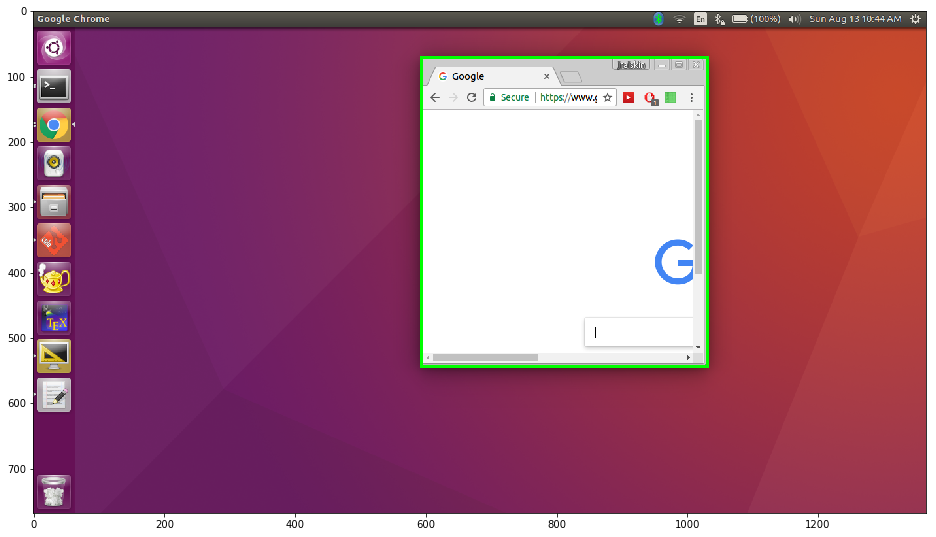

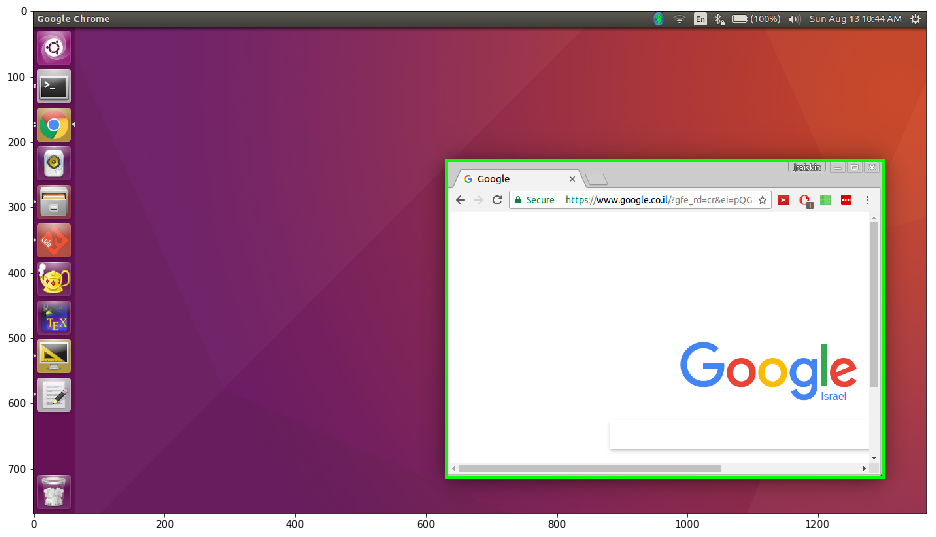

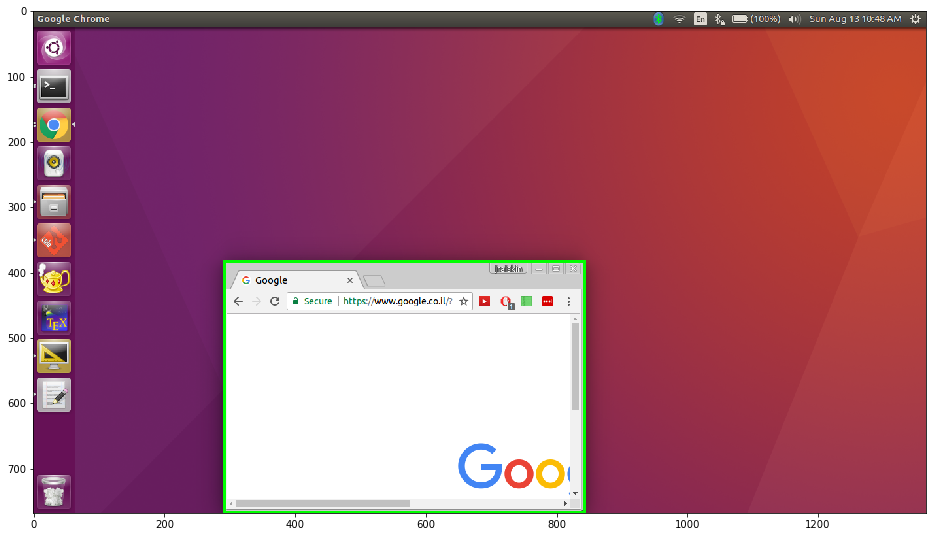

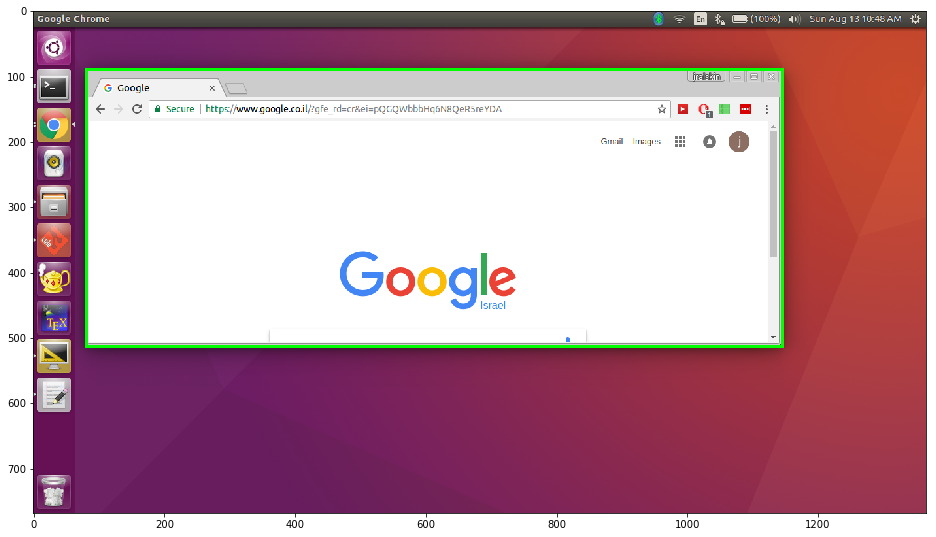

In [13]:
for i in range(1, 1+2):
    draw_boxes_from_img('{}.png'.format(i),
                        'training_set', 
                        ).show()

for i in range(161, 161+2):
    draw_boxes_from_img('{}.png'.format(i),
                        'test_set', 
                        ).show()

## Load Inference Graph (partly trained)

In [14]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join('my_semi_trained_inference_graph',
                            'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('ssd_mobilenet_v1_coco_11_06_2017', 
                              'object-detection.pbtxt')

NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [15]:
PATH_TO_TEST_IMAGES_DIR = 'test_set'
TEST_IMAGE_PATHS = [os.path.join(
    '..', 
    'image_resources', 
    PATH_TO_TEST_IMAGES_DIR, 
    '{}.png'.format(i)) for i in range(161, 161+2)]

# Size, in inches, of the output images.
image_scaling_factor = 1.5
IMAGE_SIZE = (12*image_scaling_factor, 
              8*image_scaling_factor)

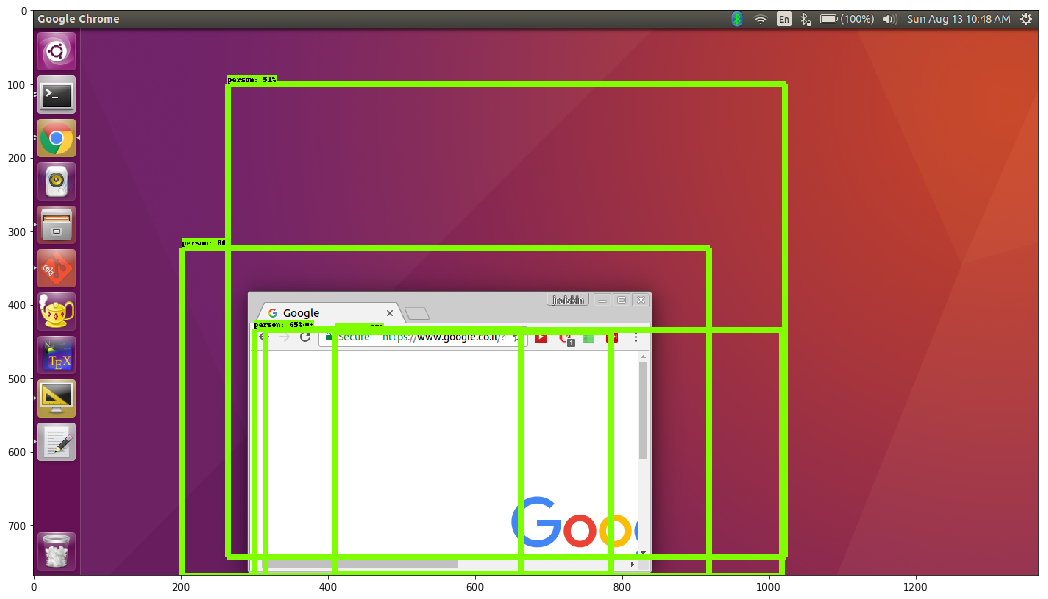

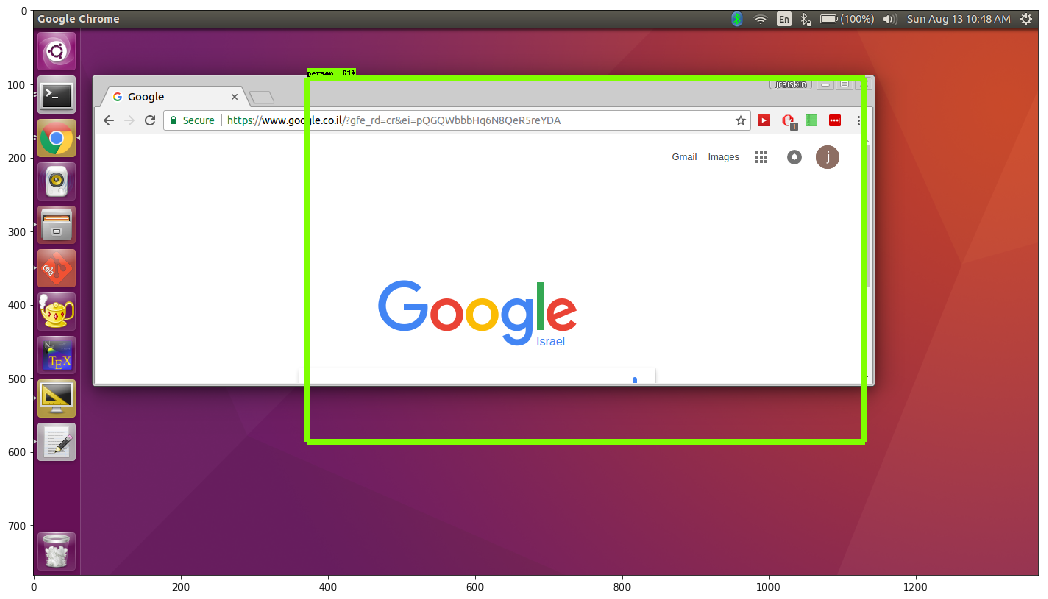

In [16]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)